# Task 1 (5 points)

Given a system:


$
\begin{cases}
\dot x =
\begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
 n & -2 & -10/n & -2 \\
-5 & -n/10 & 0 & -3
\end{bmatrix}
x
+
\begin{bmatrix}
0 \\
0 \\
-1\\
1
\end{bmatrix}
u \\
y = \begin{bmatrix}
1 & 1 & 0 & 0
\end{bmatrix} x
\end{cases}
$

where $n$ is my number in my group list - 2.



1. Find its transfer function representation ($y(s) / u(s) = W(s)$).

## 1.1 Find its transfer function representation ($y(s) / u(s) = W(s)$).

In [61]:
import ffmpeg as ffmpeg
import numpy as np
import pg8000 as pg8000
from scipy.integrate import odeint
from scipy.linalg import solve_continuous_are as are
from matplotlib.pyplot import *
from IPython.display import display
import sympy
from sympy import Matrix, diag, symbols, init_printing, pprint, factor, zeros, simplify, latex
from scipy import signal
from control import dlqr

init_printing(use_unicode=True)

A = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [2, -2, -10 / 2, -2], [-5, -2 / 10, 0, -3]])
B = np.array([[0], [0], [-1], [1]])

s = symbols('s')
n = symbols('n')

In [62]:
def find_w(A, B, C, D=None):
    M = sympy.eye(A.shape[0])
    M = M * s - A
    if D is None:
        return simplify(sympy.apart(simplify(C * (M.inv() * B)), s))
    else:
        return simplify(sympy.apart(simplify(C * (M.inv() * B) + D), s))


Am = Matrix([[0, 0, 1, 0], [0, 0, 0, 1], [n, -2, -10 / n, -2], [-5, -n / 10, 0, -3]])
Bm = Matrix([[0], [0], [-1], [1]])
Cm = Matrix([1, 1, 0, 0]).transpose()

print("Let's use formula W(s) = Y(s)/u(s) = C *(sI - A)^(-1)*B:")
W = find_w(Am, Bm, Cm)
W = W.subs(n, 2)
display("W(s) = ", W)

Let's use formula W(s) = Y(s)/u(s) = C *(sI - A)^(-1)*B:


'W(s) = '

⎡                  -16                  ⎤
⎢───────────────────────────────────────⎥
⎢      4        3        2              ⎥
⎣- 20⋅s  - 160⋅s  - 264⋅s  + 300⋅s + 208⎦

## 1.2.  Propose an ODE representation of the system.
\begin{equation}
    \begin{cases}
        x_1' = x_3\\
        x_2' = x_4\\
        x_3' = 2x_1 - 2x_2 - 5x_3 - 2x_4 - u\\
        x_4' = -5x_1 - 0.2x_2 - 3x_4 + u\\
        y = x_1 + x_2
    \end{cases}\,
\end{equation}

\begin{equation}
    \begin{cases}
        x_1'' = 2x_1 - 2x_2 - 5(x_1' +С_1) - 2(x_2'+ С_2) - u\\
        x_2'' = -5x_1 - 0.2x_2 - 3(x_2'+С_2) + u\\
        y = x_1 + x_2
    \end{cases}\,
\end{equation}

## 1.3. Propose a controller (control law $u = -Kx$) that makes the system stable. Do it via pole placement and as an LQR. For LQR show the cost function you chose.

To propose the controller, which make the system stable, rewrite the control law $u=-Kx$ into the state space form: $x'=(A-KB)x$. Now let's choose the K with 1- pole-placement and 2- LQR!
But to do it check are the methods applicable:
1- find is the system controllable,
2- find is the system observable.

In [63]:
def rank_for_check_controllability(A, B):
    R = Matrix([[0, 0, 0, 0], [0, 0, 0, 0, ], [0, 0, 0, 0], [0, 0, 0, 0]])
    R[0] = B
    R[1] = A * B
    R[2] = A * A * B
    R[3] = A * A * A * B
    rank = R.rank()
    print("Rank of the matrix R = [B AB AAB ... A^(n-1)B] is equal to ", rank)
    result = rank == R.shape[0]
    if result:
        outputStr = "The system is controllable"
    else:
        outputStr = "The system is uncontrollable"
    print(outputStr)
    return result


def rank_for_check_observability(C, A):
    O = Matrix([[0, 0, 0, 0], [0, 0, 0, 0, ], [0, 0, 0, 0], [0, 0, 0, 0]])
    Ct = C.transpose()
    At = A.transpose()
    O[0] = Ct
    O[1] = At * Ct
    O[2] = At * At * Ct
    O[3] = At * At * At * Ct
    rank = O.rank()
    print("Rank of the matrix O = [Ct AtCt AtCt ... At^(n-1)Ct] is equal to ", rank)
    result = rank == O.shape[0]
    if result:
        outputStr = "The system is observable"
    else:
        outputStr = "The system is unobservable"
    print(outputStr)
    return result


if rank_for_check_controllability(Am, Bm):
    if rank_for_check_observability(Cm, Am):
        print("We can use pool-placement for the system or LQR\nLet's do it!")
else:
    print("We can't use pool-placement and LQR :C")


Rank of the matrix R = [B AB AAB ... A^(n-1)B] is equal to  4
The system is controllable
Rank of the matrix O = [Ct AtCt AtCt ... At^(n-1)Ct] is equal to  4
The system is observable
We can use pool-placement for the system or LQR
Let's do it!


/usr/lib/python3.10/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


Use Pole Placement from scipy:

In [64]:
from scipy.signal import place_poles, ss2tf

#The system is stable when the real part of its eigenvalues are negative, so create a set of 4 negative real eigenvalues

eigP_desired = np.random.uniform(-10, -1, size=(4,))
print("Desired pole placement eigenvalues :", eigP_desired)
place_poles_lin = place_poles(A, B, eigP_desired)
Kpp = place_poles_lin.gain_matrix
print("Martix K:", Kpp)

Desired pole placement eigenvalues : [-3.21568652 -4.47098541 -6.71831777 -2.22746822]
Martix K: [[125.40539912 167.14855834  30.04097156  38.67342947]]


Use LQR:

In [65]:
def lqr(A, B, Q, R):
    # Solve the ARE
    S = are(A, B, Q, R)
    R_inv = np.linalg.inv(R)
    Klqr = R_inv.dot((B.T).dot(S))
    Ac = A - B.dot(Klqr)
    E = np.linalg.eigvals(Ac)
    return S, Klqr, E


def system_ode(x, t, A, B, Klqr):
    u = -np.dot(Klqr, x)
    dx = np.dot(A, x) + np.dot(B, u)
    return dx


t0 = 0  # Initial time
tf = 15  # Final time
N = int(2E3)  # Numbers of points in time span
t = np.linspace(t0, tf, N)  # Create time span
y_0 = 0.5
x0 = np.ones(4)  # Set initial state

Q = np.diag([1, 1, 1, 1])  #Set costs
R = np.diag([1])
S, K, E = lqr(A, B, Q, R)
x_sol = odeint(system_ode, x0, t, args=(A, B, K))  # integrate system "sys_ode" from initial state $x0$

simulations = {'fast': {'R': R / 10}, 'slow': {'R': R * 5}}

print("Martix K:", K)

Martix K: [[-6.91628181  2.07651368 -1.21141014  1.17241666]]


## 1.4. Show stability of the closed-loop system via eigenvalue analysis.

### Find eigenvalues for system with K from pole placement:

In [66]:
eigP = np.linalg.eigvals(A - B @ K)

for sim_type in simulations.keys():
    R = simulations[sim_type]['R']
    simulations[sim_type]['eigs'] = eigP
    simulations[sim_type]['K'] = Kpp
    simulations[sim_type]['x'] = odeint(system_ode, x0, t, args=(A, B, K))
    simulations[sim_type]['u'] = - K.dot(x_sol.T).T

print("Martix K:", Kpp)
print("Eigenvalues for K from polePlacement:\n", eigP, "\nDesired eigenvalues:", eigP_desired)
if eigP.max() < 0:
    print("The system is stable")
else:
    print("The system is unstable")

Martix K: [[125.40539912 167.14855834  30.04097156  38.67342947]]
Eigenvalues for K from polePlacement:
 [-0.53034896+0.j         -1.06774362+0.j         -4.39286711+0.45602049j
 -4.39286711-0.45602049j] 
Desired eigenvalues: [-3.21568652 -4.47098541 -6.71831777 -2.22746822]
The system is stable


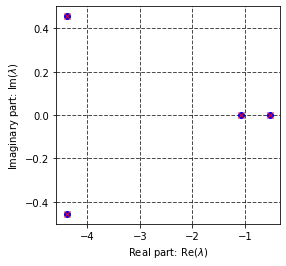

In [67]:
# Eigenvalues visualization
figure(figsize=(4, 4))
plot(simulations['fast']['eigs'].real, simulations['fast']['eigs'].imag, 'bo', label='Fast')
plot(simulations['slow']['eigs'].real, simulations['slow']['eigs'].imag, 'rx',
     label='Slow')
grid(color='black', linestyle='--', linewidth=1.0, alpha=0.7)
grid(True)
xlabel(r'Real part: ${ \operatorname{Re}(\lambda)}$')
ylabel(r'Imaginary part: ${ \operatorname{Im}(\lambda)}$')
show()

### Find eigenvalues for system with K from LQR:

In [68]:
for sim_type in simulations.keys():
    R = simulations[sim_type]['R']
    S, K, E = lqr(A, B, Q, R)
    simulations[sim_type]['eigs'] = E
    simulations[sim_type]['K'] = K
    simulations[sim_type]['x'] = odeint(system_ode, x0, t, args=(A, B, K))
    simulations[sim_type]['u'] = - K.dot(x_sol.T).T
print("Eigenvalues for LQR are equal to: ", E)
print(K)

Eigenvalues for LQR are equal to:  [-0.52507157+0.j        -1.07337208+0.j        -4.29962854+0.4480173j
 -4.29962854-0.4480173j]
[[-6.86487908  1.94316742 -1.14482729  1.05287345]]


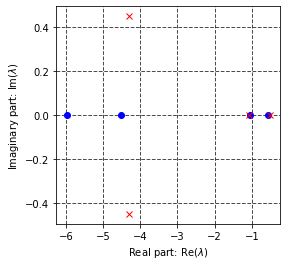

In [69]:
# Eigenvalues visualization
figure(figsize=(4, 4))
plot(simulations['fast']['eigs'].real, simulations['fast']['eigs'].imag, 'bo', label='Fast')
plot(simulations['slow']['eigs'].real, simulations['slow']['eigs'].imag, 'rx',
     label='Slow')
grid(color='black', linestyle='--', linewidth=1.0, alpha=0.7)
grid(True)
xlabel(r'Real part: ${ \operatorname{Re}(\lambda)}$')
ylabel(r'Imaginary part: ${ \operatorname{Im}(\lambda)}$')
show()

## 1.5. Find stability margins by analysing Bode diagram for the system.

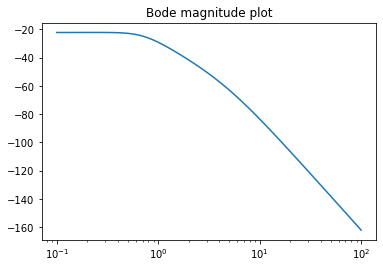

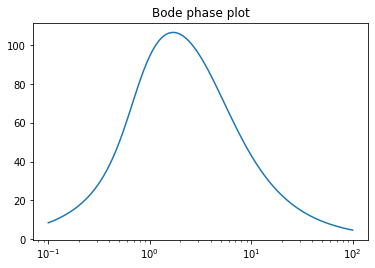

In [70]:
# a(ω) = |W(jω)| and its phase
# ϕ(ω) = atan2(im(W(jω)), real(W(jω)))

sys = signal.TransferFunction([16], [20, 160, 264, -300, 208])
array_w, mag, phase = signal.bode(sys)

figure()
title('Bode magnitude plot')
semilogx(array_w, mag)
figure()
title('Bode phase plot')
semilogx(array_w, phase)
show()

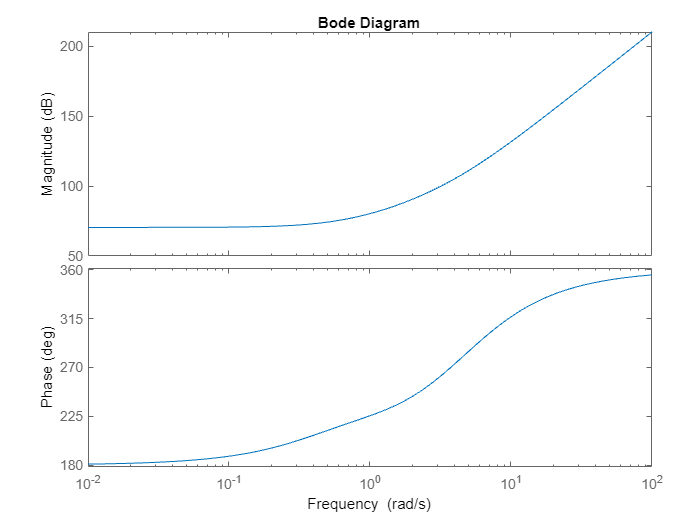

I have a different plot that MATLAB does...
But after analyzing both graphs, it seems that the system does not reach the gain margin ($gain(\omega) != 0$ or $(phase(\omega) != -180$ for any frequency value), so the system is stable!
Moreover, MATLAB says there is no stability margin.

## 1.6. Simulate closed-loop system.


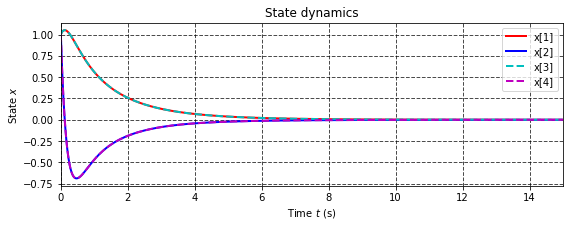

In [71]:
for sim_type in simulations.keys():
    simulations[sim_type]['x'] = odeint(system_ode, x0, t, args=(A, B, K))

figure(figsize=(9, 3))
plot(t, simulations['slow']['x'][:, 0], 'r', linewidth=2.0, label='x[1]')
plot(t, simulations['slow']['x'][:, 2], 'b', linewidth=2.0, label='x[2]')
plot(t, simulations['fast']['x'][:, 0], 'c--', linewidth=2.0, label='x[3]')
plot(t, simulations['fast']['x'][:, 2], 'm--', linewidth=2.0, label='x[4]')
legend()
grid(color='black', linestyle='--', linewidth=1.0, alpha=0.7)
grid(True)
xlim([t0, tf])
ylabel(r'State ${x}$')
xlabel(r'Time $t$ (s)')
title('State dynamics')
show()

## 1.7. Modify the control law
in such a way that the state of the system converges to $x_0 = \begin{bmatrix}
(2+0.1n)/(n-5) \\
1 \\
0 \\
0
\end{bmatrix}$. Show resulting control law. Simulate the system and demonstrate convergence via graphs of state dynamics and error dynamics.

In [72]:
Km = np.array([[0,0,0,0]])
y_0 = 0.5
C = np.array([-2.2 / 3, 1, 0, 0])  # initial state, in affine control we will use the state as C
x_sol = odeint(system_ode, C, t, args=(A, B, Km))  # integrate system "sys_ode" from initial state $x0$

Q = np.diag([1, 1, 1, 1])
R = np.diag([1])
simulations = {'fast': {'R': R}, 'slow': {'R': R}}

print("Martix K:", Km)

Martix K: [[0 0 0 0]]


#### $u = \begin{bmatrix}
6.84\\
-1.94\\
1.14\\
-1.05
\end{bmatrix} x$

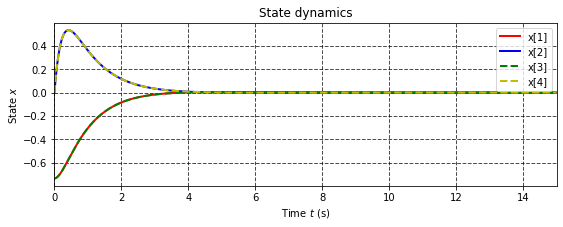

In [73]:
# e0 = [0, 0, 0, 0]

for sim_type in simulations.keys():
    R = simulations[sim_type]['R']
    S, K, E = lqr(A, B, Q, R)
    simulations[sim_type]['eigs'] = E
    simulations[sim_type]['K'] = K
    simulations[sim_type]['x'] = odeint(system_ode, C, t, args=(A, B, K))
    # u_star = np.linalg.pinv(B) * (x_sol - A * C)
    # simulations[sim_type]['error'] = A*
    simulations[sim_type]['u'] = - K.dot(x_sol.T).T

figure(figsize=(9, 3))
plot(t, simulations['slow']['x'][:, 0], 'r', linewidth=2.0, label='x[1]')
plot(t, simulations['slow']['x'][:, 2], 'b', linewidth=2.0, label='x[2]')
plot(t, simulations['fast']['x'][:, 0], 'g--', linewidth=2.0, label='x[3]')
plot(t, simulations['fast']['x'][:, 2], 'y--', linewidth=2.0, label='x[4]')
legend()
grid(color='black', linestyle='--', linewidth=1.0, alpha=0.7)
grid(True)
xlim([t0, tf])
ylabel(r'State ${x}$')
xlabel(r'Time $t$ (s)')
title('State dynamics')
show()

To determine error dynamics, use the formula from affine control $u^{*} = B^{+}(\dot x^{*} - Ax^{*})$

In [74]:
u_star = np.linalg.pinv(B) * (x_sol[0] - A * C)
print(u_star)

[[-0.  0. -0.  0.]
 [-0.  0. -0.  0.]
 [ 0.  0. -0.  0.]
 [-0.  0. -0.  0.]]


Since $u^* = 0$, $v=u$
#### The final error dynamical system equation is: $\dot e = Ae+Bu$

In [75]:
def StateSpace(x, t, A, B, K, x_des, dx_des):
    u_ff = np.linalg.pinv(B) @ (dx_des - A @ x_des)
    u_fb = - K @ (x-x_des)
    u = u_fb + u_ff
    return A @ x + B @ u


x_des = np.array([3, 0])
dx_des = np.array([0, 0])
x0 = np.array([-4, 0])
StateSpace(x0, t, A, B, K, x_des, dx_des)
x_sol = odeint(StateSpace, x0, t, args=(A, B, K, x_des, dx_des))
y, dy = x_sol[:,0], x_sol[:,1]
plot(t, y, 'r', linewidth=2.0, label = r'Position $y$ (m)')
plot(t, dy, 'b', linewidth=2.0, label = r'Velocity $\dot{y}$ (m/s)')
legend()
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
ylabel(r'System state')
xlabel(r'Time $t$ (s)')
show()
plot(y, dy, 'r', linewidth = 2.)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
ylabel(r'Velocity $\dot{y}$ (m/s)')
xlabel(r'Position $y$ (m)')
xlim([-10, 10])
ylim([-10, 10])
show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 4)

In [76]:
def trajectory(t):
    x_des = np.array([np.sin(t),np.cos(t)])
    dx_des = np.array([np.cos(t),-np.sin(t)])
    return x_des, dx_des


def StateSpace_trajectory(x, t, A, B, K):
    x_des, dx_des = trajectory(t)
    u_ff = np.linalg.pinv(B) @ (dx_des - A @ x_des)
    u_fb = - K @ (x-x_des)
    u = u_fb + u_ff
    return A @ x + B @ u


K = np.array([[3,4]])
x_des = C
dx_des = np.array([0, 0, 0, 0])
x0 = np.array([0, 0, 0, 0])
StateSpace(x0, t, A, B, K, x_des, dx_des)
x_sol = odeint(StateSpace_trajectory, x0, t, args=(A, B, K))
y, dy = x_sol[:,0], x_sol[:,1]
plot(t, y, 'r', linewidth=2.0, label = r'Position $y$ (m)')
plot(t, dy, 'b', linewidth=2.0, label = r'Velocity $\dot{y}$ (m/s)')
legend()
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
ylabel(r'System state')
xlabel(r'Time $t$ (s)')
show()
plot(y, dy, 'r', linewidth = 2.)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
ylabel(r'Velocity $\dot{y}$ (m/s)')
xlabel(r'Position $y$ (m)')
xlim([-10, 10])
ylim([-10, 10])
show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 2)

## 1.8.Discretize the system with $\Delta t = 0.01$. Write equations of the discrete dynamics.
$ \dot x \approx \frac{1}{\Delta t}*(x(t)-x(t-\Delta t)) \\
\dot x \approx \frac{1}{\Delta t}*(x_{i+1}-x_{i}) = Ax_i \\
x_{i+1} = (I - A \Delta t)^{-1} x_i$


Define discrete state space matrix $\bar{A} = A \Delta t + I$ and discrete control matrix $\bar{B} = B \Delta t\\$.
So, we get the discrete dynamics system:
$\begin{cases}x_{i+1} = \bar{A} x_i + \bar{B} u_i\\
y_{i+1} = Cx_i\end{cases}$

In [77]:
dt = 0.01
I = np.diag([1, 1, 1, 1])
Ad = I + A * dt
Bd = B * dt
print("Ad =", Ad, "\nBd=", Bd)

Ad = [[ 1.     0.     0.01   0.   ]
 [ 0.     1.     0.     0.01 ]
 [ 0.02  -0.02   0.95  -0.02 ]
 [-0.05  -0.002  0.     0.97 ]] 
Bd= [[ 0.  ]
 [ 0.  ]
 [-0.01]
 [ 0.01]]


It is easy to write down the equation for the system dynamics:
$\begin{cases}x_{i+1} = \begin{bmatrix} 1& 0& 0.01&0\\
 0&1&0&0.01\\
 0.02& -0.02& 0.95& -0.02\\
 -0.05 & -0.002&0& 0.97
 \end{bmatrix}x_i + \begin{bmatrix} 0\\0\\-0.01\\0.01 \end{bmatrix} u_i\\
y_{i+1} = \begin{bmatrix} 1&1&0&0
\end{bmatrix}x_i\end{cases}$

## 1.9. Propose a control law for the discrete system via pole-placement and LQR (show cost function for the LQR).

In general, discrete systems are stable as long as $|\lambda _ i(A)| \leq 1$.


In [78]:
# Find desired eigenvalues for control law
eigD_desired = np.random.uniform(-0.999999, 0.999999, size=(4,))
place_poles_disc = place_poles(Ad, Bd, eigD_desired)
Kd_pp = place_poles_disc.gain_matrix
print("Desired eigenvalues: ", eigD_desired, "\n K matrix: ", Kd_pp)
print("\n\nControl law via pole-pplacement: \nu_i = -", Kd_pp.T, "x_i")

Desired eigenvalues:  [-0.59088388  0.48640933 -0.33981218  0.50655199] 
 K matrix:  [[67330064.86371936 67381485.19839531  3288714.53507553  3289100.30855039]]


Control law via pole-pplacement: 
u_i = - [[67330064.86371936]
 [67381485.19839531]
 [ 3288714.53507553]
 [ 3289100.30855039]] x_i


In [79]:
from scipy.linalg import solve_discrete_are

t0 = 0  # Initial time
tf = 15  # Final time
N = int(2E3)  # Numbers of points in time span
t = np.linspace(t0, tf, N)  # Create time span
y_0 = 0.5
x0 = np.array([0, 0, 0, 0])  # Set initial state

Q = np.diag([1, 2, 3, 4])  #Set costs
R = np.diag([1])
P = solve_discrete_are(Ad, Bd, Q, R)
print("P=", P)
Kd = np.linalg.inv(R) @ Bd.T @ P
Al = np.eye(4) + Ad - Bd @ Kd
print(np.linalg.eigvals(Al))

print("\nMatrix K:", Kd)
print("\n\nControl law via LQR:\nu_i= -", Kd.T, "x_i")
print( "cost function:", x0.T@P@x0 )

P= [[2403.41259915 -595.91460149  378.89858952 -310.7108269 ]
 [-595.91460149  493.912318    -91.74095976  136.2004981 ]
 [ 378.89858952  -91.74095976   88.71323775  -46.87471136]
 [-310.7108269   136.2004981   -46.87471136  106.3918401 ]]
[1.95316077+0.0032682j 1.95316077-0.0032682j 1.99012669+0.j
 1.99466631+0.j       ]

Matrix K: [[-6.89609416  2.27941458 -1.35587949  1.53266551]]


Control law via LQR:
u_i= - [[-6.89609416]
 [ 2.27941458]
 [-1.35587949]
 [ 1.53266551]] x_i
cost function: 0.0


## 1.10. Show eigenvalue analysis of the closed-loop dynamics of the discrete system (with the proposed discrete control law. Demonstrate stability.

In [80]:
eig10 = np.linalg.eigvals(Ad - Bd @ Kd)

for sim_type in simulations.keys():
    R = simulations[sim_type]['R']
    simulations[sim_type]['eigs10'] = eig10

print("Eigenvalues for K from polePlacement:\n", eig10)
if eig10.max() < 0:
    print("The system is stable")
else:
    print("The system is unstable")


Eigenvalues for K from polePlacement:
 [0.95316077+0.0032682j 0.95316077-0.0032682j 0.99012669+0.j
 0.99466631+0.j       ]
The system is unstable


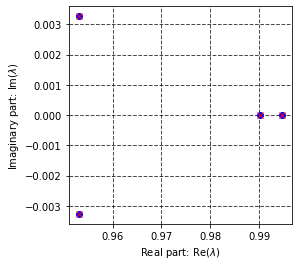

In [81]:
# Eigenvalues visualization
figure(figsize=(4, 4))
plot(simulations['fast']['eigs10'].real, simulations['fast']['eigs10'].imag, 'bo', label='Fast')
plot(simulations['slow']['eigs10'].real, simulations['slow']['eigs10'].imag, 'rx',
     label='Slow')
grid(color='black', linestyle='--', linewidth=1.0, alpha=0.7)
grid(True)
xlabel(r'Real part: ${ \operatorname{Re}(\lambda)}$')
ylabel(r'Imaginary part: ${ \operatorname{Im}(\lambda)}$')
show()

## 1.11. Simulate the discrete system. Show graphs.

In [82]:
def plot_solution(x, t, control: str = " "):
    figure()
    if control== " ": title("System dynamics")
    else: title(f"System dynamics {control}")
    colors = ['b', 'r', 'c', 'm']
    for i in range(x.shape[1]):
        step(t, x[:, i], linewidth=2.0, color=colors[i], label="x" + str(i))
    grid(True, color='black', linestyle='--', linewidth=1.0, alpha=0.7)
    legend()
    show()
    # plot(t, simulations['slow']['x'][:, 0], 'r', linewidth=2.0, label='x[1]')
    # plot(t, simulations['slow']['x'][:, 2], 'b', linewidth=2.0, label='x[2]')
    # plot(t, simulations['fast']['x'][:, 0], 'g--', linewidth=2.0, label='x[3]')
    # plot(t, simulations['fast']['x'][:, 2], 'y--', linewidth=2.0, label='x[4]')

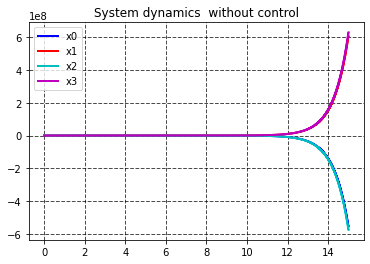

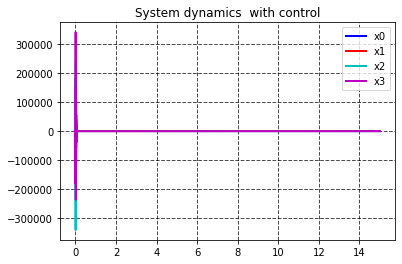

In [83]:
def x_next(x, Ad, Bd, k):
    return (Ad - Bd @ k) @ x


def w_or_wo_control(control, k):
    x = C
    xs = [x]

    for t_ in t[:-1]:
        x = x_next(x, Ad, Bd, k)
        xs.append(x)

    solution = np.array(xs)
    control = " with control" if control else " without control"
    plot_solution(solution, t, control)


# discrete system without control
w_or_wo_control(False, np.eye(1))
# discrete system with control
w_or_wo_control(True, Kd_pp)

# Task 2 (4 points)

You are given a system:

$$
\begin{cases}
\dot x =
\begin{bmatrix}
1 & 5 & -2 \\
2 & 1 & -3 \\
-1 & -2 & 7
\end{bmatrix}
x
+
\begin{bmatrix}
2 \\
1 \\
0
\end{bmatrix}
u \\
u = -\begin{bmatrix}
7k & 6k & -50k
\end{bmatrix} x
\end{cases}
$$

## 1. How do the eigenvalues of the closed-loop system depend on k? Plot the evolution of the eigenvalues on a complex plane, as $k$ changes from 0 to 5.

In [84]:
An = np.array([[1, 5, -2], [2, 1, -3], [-1, -2, 7]])
Bn = np.array([[2], [1], [0]])


def k_matrix(k):
    return np.array([[7, 6, -50]]) * k


def find_eig(k):
    K = k_matrix(k)
    return np.linalg.eig(An - Bn @ K)


def system_ode(x, t, A, B, Klqr):
    u = -np.dot(Klqr, x)
    dx = np.dot(A, x) + np.dot(B, u)
    return dx



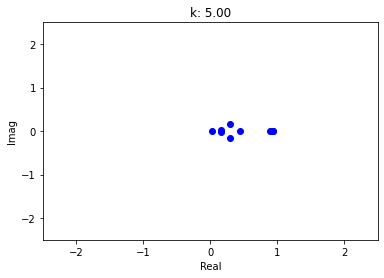

In [85]:
from matplotlib import animation
from numpy.ma import count
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
# ax = plt.axes(xlim=(-25, 150), ylim=(-10, 10))
ax = plt.axes(xlim=(-2.5, 2.5), ylim=(-2.5, 2.5))
ax.set_xlabel('Real')
ax.set_ylabel('Imag')
line, = ax.plot([], [], 'bo')


# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,


# animation function.  This is called sequentially
def animate(i):
    res = find_eig(i)
    for key in res:
        simulations[sim_type]['eigs'] = key

    x = np.array(simulations[sim_type]['eigs'].real)
    y = np.array(simulations[sim_type]['eigs'].imag)
    line.set_data(x, y)
    ax.set_title(f'k: %.2f' % i)
    return line,


# Create time span
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=np.linspace(0, 5, 300),
                               interval=60, blit=True)

anim.save('basic_animation.mp4', fps=15)

In [86]:
from IPython import display
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

## 2.2 Chose a value of $k$ that allows the system to be stable. Use bode plot to find stability margins of the closed-loop system.

### k=3.19
To make bode plot, find transfer function:

In [87]:
Kn = np.array([[7*3.19, 6*3.19, -50*3.19]])
print(An.shape, Bn.shape, Kn.shape)

(3, 3) (3, 1) (1, 3)


In [88]:
eign = np.linalg.eigvals(An - Bn @ Kn)

for sim_type in simulations.keys():
    R = simulations[sim_type]['R']
    simulations[sim_type]['eigs'] = eign
    simulations[sim_type]['K'] = Kn

print("Martix K:", Kn)
print("Eigenvalues for K from polePlacement:\n", eign)
if eigP.max() < 0:
    print("The system is stable")
else:
    print("The system is unstable")

Martix K: [[  22.33   19.14 -159.5 ]]
Eigenvalues for K from polePlacement:
 [-48.57687759+0.j          -3.11156121+0.91012708j
  -3.11156121-0.91012708j]
The system is stable


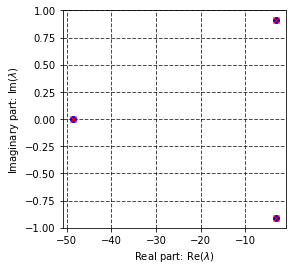

In [89]:
# Eigenvalues visualization
figure(figsize=(4, 4))
plot(simulations['fast']['eigs'].real, simulations['fast']['eigs'].imag, 'bo', label='Fast')
plot(simulations['slow']['eigs'].real, simulations['slow']['eigs'].imag, 'rx',
     label='Slow')
grid(color='black', linestyle='--', linewidth=1.0, alpha=0.7)
grid(True)
xlabel(r'Real part: ${ \operatorname{Re}(\lambda)}$')
ylabel(r'Imaginary part: ${ \operatorname{Im}(\lambda)}$')
show()

## 2.3. Discretize the closed-loop system with  Δt=0.05  and simulate both the continues-time and discrete-time versions, show if there is a difference between simulation results.

### Simulate continuous system:


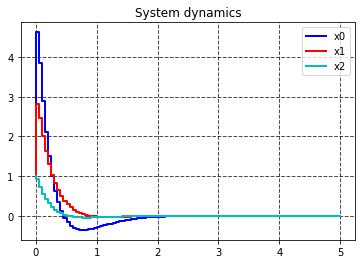

In [90]:
x0n = np.ones(3)
tn = np.linspace(0, 5, 100)
solution = odeint(system_ode, x0n, tn, args=(An, Bn, Kn))
plot_solution(solution, tn)

Simulate discrete system:

In [91]:
dt = 0.05
A_n = An * dt + np.eye(3)
B_n = Bn * dt

P = np.random.uniform(-0.9999, 0.9999, size=(3,))
pp_n = place_poles(A_n, B_n, P)
Knd = pp_n.gain_matrix

In [92]:
def discrete_sys_vis():
    x = np.ones(3)
    xs = [x]
    for t_ in tn[:-1]:
        x = x_next(x, A_n, B_n, Knd)
        xs.append(x)
    solution = np.array(xs)
    plot_solution(solution, tn)



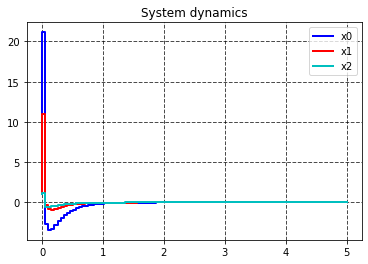

In [93]:
discrete_sys_vis()

It is easy to see that continuous system is more controllable than discrete one

## 2.4. What is the smallest value of k that makes the eigenvalues purely real?

In [94]:
space_k = np.linspace(-10, 10, 1000)
j=0
for (i,k) in enumerate(space_k):
  u_4 = np.array([[(7*k), (6*k), (-50*k)]])
  eig = np.linalg.eigvals(An-np.dot(Bn, u_4))
  if (eig.imag == 0).all():
    print(f'k = {k} \nEigenvalues: {eig}')
    j = i
    break

for k in space_k[j:]:
  u_4 = np.array([[(7*k), (6*k), (-50*k)]])
  eig = np.linalg.eigvals(An-np.dot(Bn, u_4))
  if (np.imag(eig) == 0).all() and (np.real(eig) < 0).all():
    print(f"k={k} \nEigenvalues: {eig}")
    break

k = -0.6906906906906904 
Eigenvalues: [25.67320321 -1.31691077 -1.54247863]
k=1.591591591591591 
Eigenvalues: [-11.49573432  -8.4744654   -2.86163212]


The smallest value of k: $k ≃−0.69$ for unstable system
The smallest value of k: $k ≃−0.69$ for stable system

# Task 3 (3 points)

You are given a system:

$$
\begin{cases}
\dot x =
\begin{bmatrix}
0 & 1 \\
1 & 10
\end{bmatrix}
x
+
\begin{bmatrix}
0 \\
1
\end{bmatrix}
u \\
u =
-\begin{bmatrix}
5k & k
\end{bmatrix} x
\end{cases}
$$

You can chose any positive value of $k$ to design your controller. What is least-norm control gain (control gain is the matrix $\begin{bmatrix}
5k & k
\end{bmatrix}$) that makes the system not only be stable, but also exhibit no oscillations in the transient process?


Lets substitute u:
$$
\dot x =
\begin{bmatrix}
0 & 1 \\
1 & 10
\end{bmatrix}
x - \begin{bmatrix}
0 & 0\\
5k & k \end{bmatrix} x$$
Stability of the system in the transient process is defined by damping ratio and eigenvalues. When the damping ratio ζ is greater than one, the two roots of
the characteristic equation are real and negative, system is overdamped.
$det \big(\begin{bmatrix} -\lambda & 1\\
1 - 5k & 10-k \end{bmatrix} =0\\
\lambda(\lambda +k -10) + 5k -1 = 0\\
\lambda ^2 +(k-10)\lambda + (5k-1)=0\\
\lambda = \frac{10 - k \pm \sqrt{(k - 10)^2 - 4(5k-1)}}{2}\\
\lambda = \frac{10 - k \pm \sqrt{k^2 - 40k + 104}}{2}\\
$

$
\begin{cases}
10-k + \sqrt{k^2-40k+104} < 0\\
k^2-40k+104 > 0 \end{cases}\\
\begin{cases}
k \geq 37.2047 \\
k \geq 20+ 2\sqrt {74} \\
k \leq  20 - 2\sqrt{74}\end{cases}\\
$

$
k \in (20+ 2\sqrt {74}  ;∞)
$


The least-norm control law is the one with the lowest possible value of k
Therefore, answer is: $K = 20 +2\sqrt{74} \approx 37.205 $